To run notebook in dashboard mode, first evaluate all cells. Then select View -> Dashboard Preview.

In [2]:
%matplotlib notebook

# Interactive Dendrogram Dashboard

Select diagram type, then index. This will calculate the dendrogram for the given type 
and display the image with the corresponding index. To explore further, just select a new index, or type.

<IPython.core.display.Javascript object>


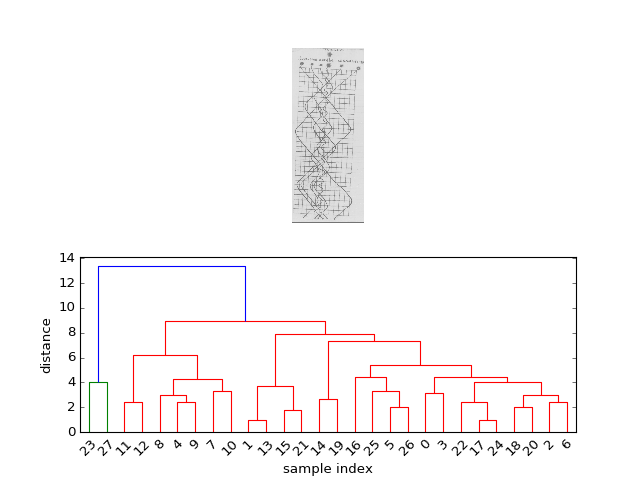

In [3]:
from ipywidgets import widgets, fixed
from ipywidgets import *
from IPython.display import display
from io import BytesIO

import pandas as pd
from collections import OrderedDict

from skimage import data as dt
from skimage import filters, io
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from medDiaJson import * 
from roman_date import from_roman

url = 'https://raw.githubusercontent.com/grasshoff/ComputationalHistoryScience/master/diaattr.json'
diagrams = pd.read_json(url)

keyList = [str(x) for x in set(diagrams['diaTyp']) if x not in ['',0.0]]

indexList = [[str(x) for x in (reducedData(diagrams,[['diaTyp',float(x)]])).index.tolist()] for x in keyList]            

dtyDict = OrderedDict([(x,y) for x,y in zip(keyList,indexList)])

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
#axs[0,0].plot(x)

def select_typ(DiagramType=1.0):
    global glTYP
    glTYP=float(DiagramType)
    with indexes.hold_trait_notifications():
        indexes.options = dtyDict[DiagramType]
        #view_image(0)

def imageGet(i,diaTypes):
    dfred = reducedData(diagrams,[['diaTyp',diaTypes]])
    file = getFileBinary((dfred['diaID']).loc[int(i)])
    if type(file) == str:
        image = np.ones((10,3,3))
        pass
    else:
        image = io.imread(BytesIO(file))
    return image

    
def title(Index):
    title = ' '.join(diaTypeDescr(Index).split('\n')[0].split()[0:2])
    return title

def image_dendrogram(Index):
    fig, axs = plt.subplots(2, 1, sharex=False, sharey=False)

    DiagramType=glTYP

    descr = diaTypeDescr(DiagramType).split('\n')

    title = 'Dendrogram: {0}'.format(descr[0]) 

    axs[0].imshow(imageGet(Index,glTYP), cmap=plt.cm.gray_r, interpolation='none')

    fig.set_label(title)

    axs[0].axis('off')

    Mtyp=reducedData(diagrams,[["diaTyp",DiagramType]])

    merkmaleV=Mtyp[["diaID","diaAttr"]].reset_index(drop=True)

    frames=[]
    for i in merkmaleV["diaAttr"]:
        j=pd.DataFrame(i)
        frames.append(j)

    MerkmaleDia=pd.concat(frames,ignore_index=True)

    # Data cleaning
    rplBy = -1
    vlList = list(pd.unique(MerkmaleDia.values.ravel()))
    if '?' in vlList:
        MerkmaleDia.replace(['?'],[rplBy],inplace=True)
    elif np.isnan(vlList).any():
        MerkmaleDia.replace([np.float64(None)],[rplBy],inplace=True)
    elif 'no attributes' in vlList:
        MerkmaleDia.replace(['no attributes'],[rplBy],inplace=True)
    elif '' in vlList:
        MerkmaleDia.replace([''],[rplBy],inplace=True)
    else:
        pass

    X = MerkmaleDia.values

    metric = 'euclidean'

    Z = linkage(X, method='ward',metric=metric)

    plt.xlabel('sample index')# or (cluster size)')
    plt.ylabel('distance')
    dendrogram(
        Z,
        #truncate_mode='lastp',  # show only the last p merged clusters
        #p=30,  # show only the last p merged clusters
        #leaf_rotation=90.,
        leaf_font_size=12.,
        #show_contracted=True,
        ax=axs[1]
    );

    
types = widgets.Select(options=list(dtyDict.keys()))

init = types.value

indexes = widgets.Select(options=list(dtyDict[init]))

i = widgets.interactive(select_typ, DiagramType=types)

j = widgets.interactive(image_dendrogram, Index=indexes)


HBox([i,j])